In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tracpy
import tracpy.calcs
from tracpy.tracpy_class import Tracpy
import os
import numpy as np
import cartopy.crs as ccrs
import xarray as xr
from glob import glob
import netCDF4 as netCDF
import cmocean.cm as cmo
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.patches as patches


/Users/kthyng/miniconda3/envs/tracpy/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/kthyng/miniconda3/envs/tracpy/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

ImportError: numpy.core.multiarray failed to import

In [2]:
import numpy
print numpy.__version__


1.12.1


# Spatial changes in cell counts


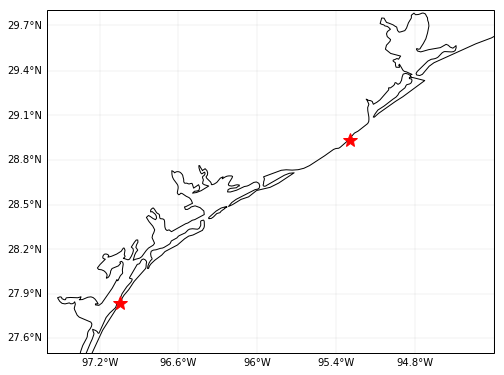

In [4]:
# map of domain
latpa, lonpa = 27.834750, -97.047372
latss, lonss = 28.934928, -95.294881

fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.set_extent([-97.6, -94.2, 27.5, 29.8], ccrs.PlateCarree())
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'
ax.plot([lonpa, lonss], [latpa, latss], 'r*', markersize=15, transform=ccrs.PlateCarree())

# # port aransas, previously saved seed locations
# dtemp = np.load('calcs/ll0_pa.npz')
# lon0 = dtemp['lon0']; lat0 = dtemp['lat0']

# # plot
# fig = plt.figure()
# figname = 'figures/ll0_pa.png'
# ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
# gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# ax.set_extent([-97.5, -96.7, 27.5, 28.2], ccrs.PlateCarree())
# ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'
# ax.plot(lon0, lat0, 'r.', transform=ccrs.PlateCarree());
# fig.savefig(figname, bbox_inches='tight')

## Identify coastal boxes

In order to use my previous analysis setup, I want the coastal box containing each cytobot, and perhaps also each neighbor.

This shows that the coastal boxes to use are as follows:
* Port Aransas: 112, 113, 114
* Surfside: 155, 156, 157

Original code is from shelf_transport/notebookes/Coastal connectivity calculations.ipynb.

//anaconda/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


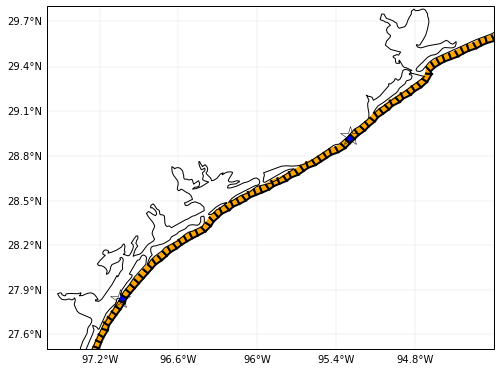

In [26]:
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.set_extent([-97.6, -94.2, 27.5, 29.8], ccrs.PlateCarree())
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

# plot boxes
pathsll = np.load('../shelf_transport/calcs/coastpaths.npz', encoding='latin1')['paths']
for i, path in enumerate(pathsll):
    if i == 113:  # PA
        patch = patches.PathPatch(path, facecolor='blue', lw=2, transform=ccrs.PlateCarree())
    elif i == 156:  # SS
        patch = patches.PathPatch(path, facecolor='blue', lw=2, transform=ccrs.PlateCarree())
    else:
        patch = patches.PathPatch(path, facecolor='orange', lw=2, transform=ccrs.PlateCarree())
    ax.add_patch(patch)
        
    
# plot cytobots
ax.plot([lonpa, lonss], [latpa, latss], '*', markersize=20, transform=ccrs.PlateCarree(), mfc='None')

## Connectivity Plots

Could plot in color time for any connectivity. Or amount of connectivity for a given time.

### Seasonal

## Read in cell data

In [3]:
dfpa = pd.read_csv('data/IFCB_portaransas_2017.csv', index_col=0, parse_dates=True)
dfss = pd.read_csv('data/IFCB_surfside_2017.csv', index_col=0, parse_dates=True)

## Plot cells in time

### Overall

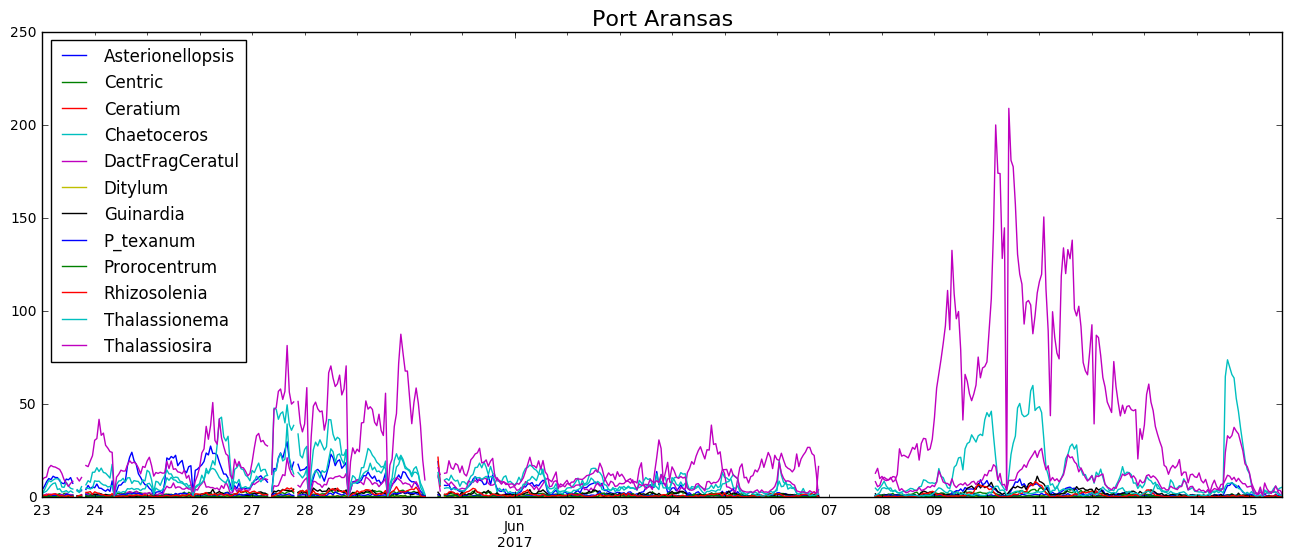

In [4]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
dfpa.plot(ax=ax)
ax.set_title('Port Aransas', fontsize=16)

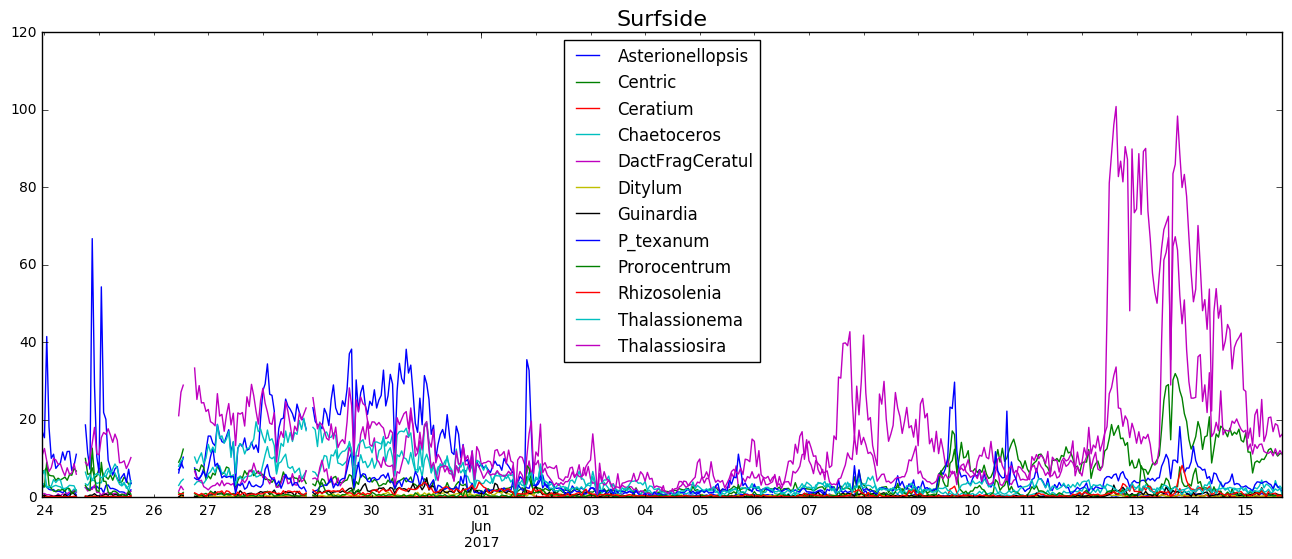

In [5]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
dfss.plot(ax=ax)
ax.set_title('Surfside', fontsize=16)

### Individual species

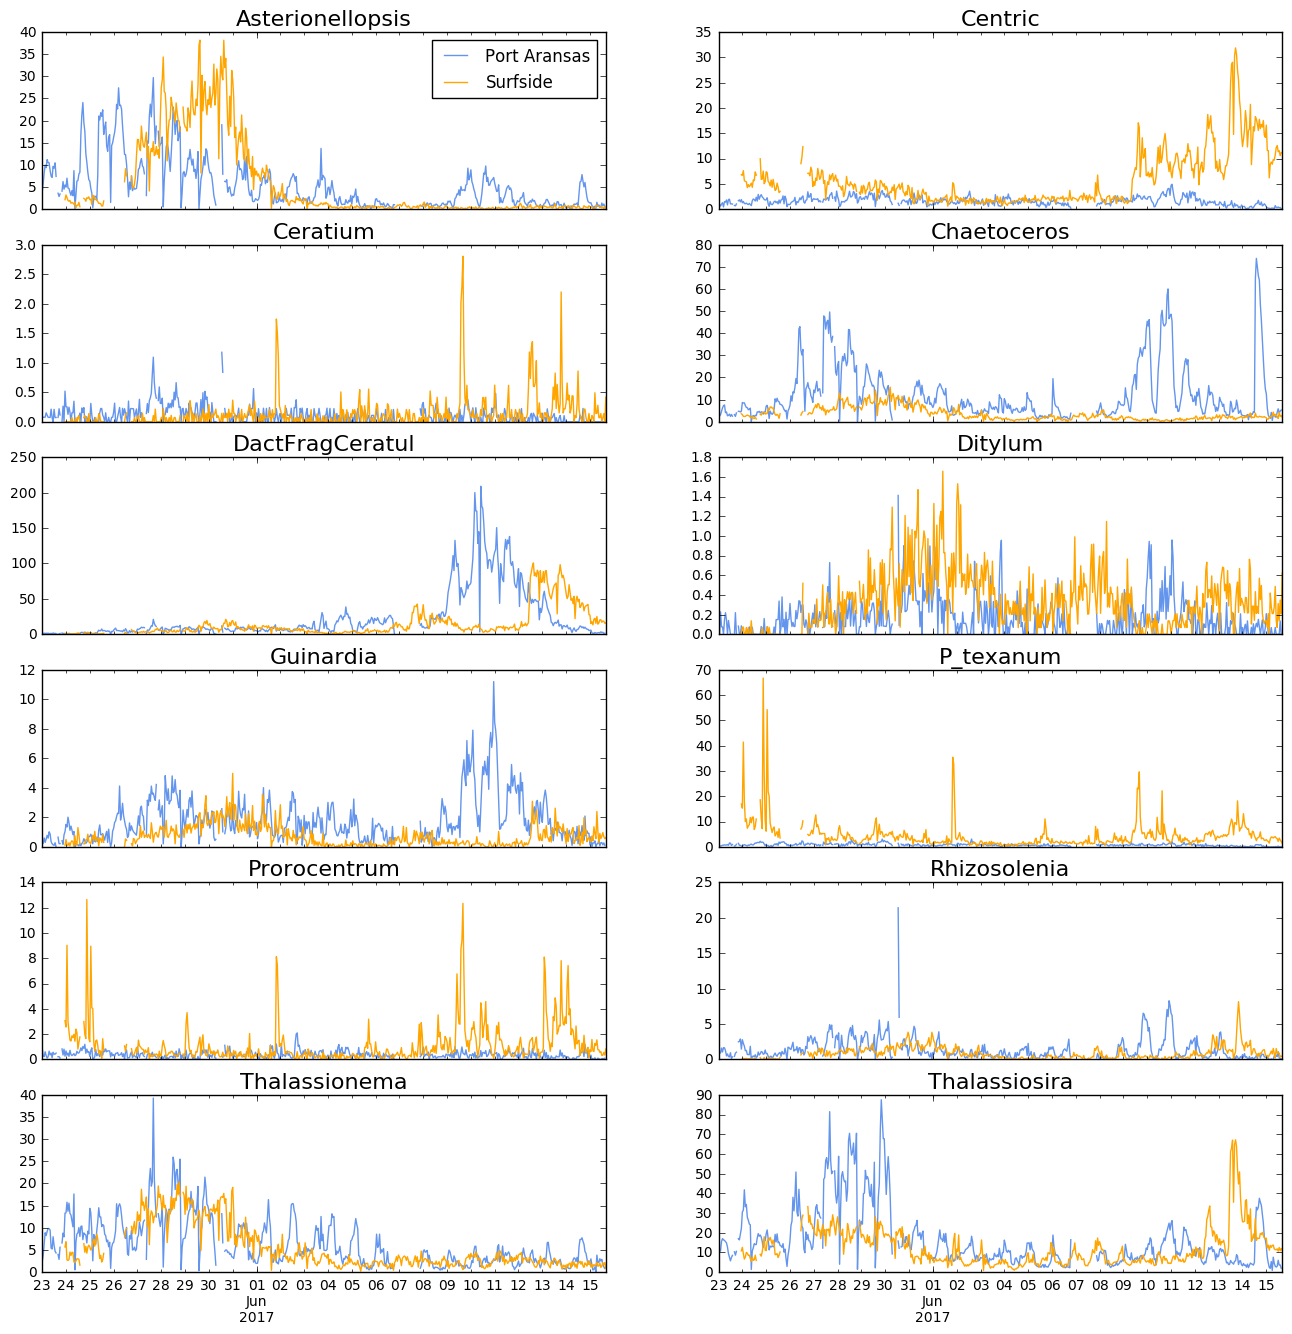

In [6]:
fig, axes = plt.subplots(6, 2, figsize=(16,16), sharex=True)
for ax, col in zip(axes.flatten(), dfpa.columns):
    dfpa[col].plot(ax=ax, color='cornflowerblue', label='Port Aransas')
    dfss[col].plot(ax=ax, color='orange', label='Surfside')
    ax.set_title(col, fontsize=16)
    if col == 'Asterionellopsis':
        ax.legend()

In [18]:
# model output location
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/oof_archive_agg'
# more grid metrics available in hindcast:
locgrid = 'http://copano.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'


In [19]:
def seeds(startarea, dx, grid):
    '''Calculate and return seed locations for desired case.'''
    
    ll0fname = 'calcs/ll0_' + startarea + '.npz'
    
    if startarea == 'pa':
        lon = lonpa; lat = latpa
    elif startarea == 'ss':
        lon = lonss; lat = latss
        
    if not os.path.exists(ll0fname):
        llcrnrlon = lon - 0.1; urcrnrlon = lon + 0.1;
        llcrnrlat = lat - 0.1; urcrnrlat = lat + 0.1;
        xcrnrs, ycrnrs = grid.proj([llcrnrlon, urcrnrlon], [llcrnrlat, urcrnrlat])
        X, Y = np.meshgrid(np.arange(xcrnrs[0], xcrnrs[1], dx), np.arange(ycrnrs[0], ycrnrs[1], dx))

        lon0, lat0 = grid.proj(X, Y, inverse=True)

        domainpathll = np.load('calcs/domain_path_nobays.npz')['path'].item()
        # points that are in the shelf domain
        inds = domainpathll.contains_points(np.vstack([lon0.flatten(), lat0.flatten()]).T).reshape(lon0.shape)

        # remove shelf points
        lon0 = lon0[inds]; lat0 = lat0[inds]

        # Eliminate points that are outside domain or in masked areas
        lon0, lat0 = tracpy.tools.check_points(lon0, lat0, grid)

        # save starting locations for future use
        np.savez(ll0fname, lon0=lon0, lat0=lat0)

    else:
        dtemp = np.load(ll0fname)
        lon0 = dtemp['lon0']; lat0 = dtemp['lat0']
        
    return lon0, lat0

In [20]:
def init(name, startdate, enddate, dx, do3d, startarea, ff=1):
    
    time_units = 'seconds since 1970-01-01  00:00:00'

    nsteps = 10

    # Number of steps to divide model output for outputting drifter location
    N = 4

    # Number of days
    ndays = (enddate-startdate).total_seconds()/86400.
    if ff == -1:  # don't want negative days for backward running case
        ndays = abs(ndays)

    # Time between outputs
    tseas = 3600.  # time between output in seconds
    ah = 0.
    av = 0.  # m^2/s

    # for 3d flag, do3d=0 makes the run 2d and do3d=1 makes the run 3d
    doturb = 0

    # for periodic boundary conditions in the x direction
    doperiodic = 0

    # Flag for streamlines. All the extra steps right after this are for streamlines.
    dostream = 0

    proj = tracpy.tools.make_proj(setup='nwgom-pyproj')

    # Read in grid
    grid = tracpy.inout.readgrid(locgrid, proj, usespherical=True)

    # get seed locations for drifters
    if startarea == 'pa' or startarea == 'ss':
        lon0, lat0 = seeds(startarea, dx, grid)
    elif startarea == 'sspa':
        lon0a, lat0a = seeds('pa', dx, grid)
        lon0b, lat0b = seeds('ss', dx, grid)
        lon0 = np.hstack((lon0a, lon0b))
        lat0 = np.hstack((lat0a, lat0b))

    ## Choose method for vertical placement of drifters
    if do3d:  # 3d
        z0 = np.zeros(lon0.shape)
        zpar = 'fromZeta'
    else:  # 2d
        z0 = 's'
        zpar = 29

    # Initialize Tracpy class
    tp = Tracpy(loc, grid, name=name, tseas=tseas,
                ndays=ndays, nsteps=nsteps, N=N, ff=ff, ah=ah, av=av,
                doturb=doturb, do3d=do3d, z0=z0, zpar=zpar,
                time_units=time_units, usespherical=True)

    return tp, lon0, lat0


## Run drifters

### Asterionellopsis: 2D

Model drifters starting May 24 through 26 until from Port Aransas and running until May 28 to see if they can reach Freeport.

In [36]:
# species and therefore simulation name
speciesname = 'Asterionellopsis'
nd = '2d'
case = 'fromsurfside'

fullname = speciesname + '/' + nd + '/' + case + '/'

if not os.path.exists('tracks/' + fullname):
    os.mkdir('tracks/' + fullname)

overallstartdate = datetime(2017, 5, 24, 0)
enddate = datetime(2017, 5, 28, 12)

date = overallstartdate

# keep running until we hit end date
while date < datetime(2017, 5, 26, 0):

    name = fullname + date.isoformat()[0:13]

    # If the particle trajectories have not been run, run them
    if not os.path.exists('tracks/' + name + '.nc') and \
        not os.path.exists('tracks/' + name + 'gc.nc'):

        tp, lon0, lat0 = init(name, date, enddate, dx=1000, do3d=0, startarea='pa')
        lonp, latp, zp, t, T0, U, V = tracpy.run.run(tp, date, lon0, lat0)

    # Increment by 12 hours for next loop
    date = date + timedelta(hours=12)


theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
Using GCM model output index  0
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
Using GCM model output index  1
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
Using GCM model output index  2
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretchi

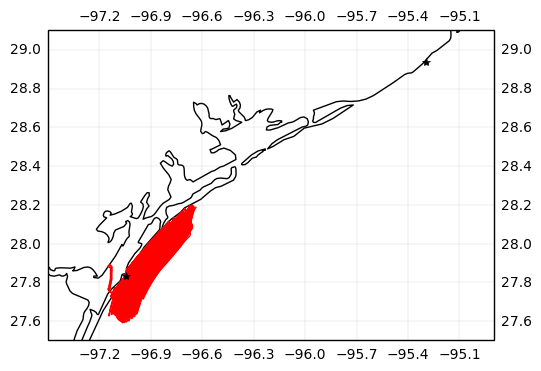

In [38]:
Files = glob('tracks/' + fullname + '*.nc')

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-97.5, -94.9, 27.5, 29.1], ccrs.PlateCarree())
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

for File in Files:
#     d = xr.open_dataset(File)
    d = netCDF.Dataset(File)
    lonp = d['lonp'][:,:]
    latp = d['latp'][:,:]
    d.close()
    ax.plot(lonp.T, latp.T, 'r', transform=ccrs.PlateCarree());

ax.plot([lonpa, lonss], [latpa, latss], 'k*', transform=ccrs.PlateCarree())
# figname = 'figures/.png'
# fig.savefig(figname, bbox_inches='tight')


### Asterionellopsis: 3D

Model drifters starting May 24 through 26 until from Port Aransas and running until May 28 to see if they can reach Freeport.

In [10]:
# species and therefore simulation name
speciesname = 'Asterionellopsis'
nd = '3d'
case = 'fromsurfside'

fullname = speciesname + '/' + nd + '/' + case + '/'

if not os.path.exists('tracks/' + fullname):
    os.mkdir('tracks/' + fullname)

overallstartdate = datetime(2017, 5, 24, 0)
enddate = datetime(2017, 5, 28, 12)

date = overallstartdate

# keep running until we hit end date
while date < datetime(2017, 5, 26, 0):

    name = fullname + date.isoformat()[0:13]

    # If the particle trajectories have not been run, run them
    if not os.path.exists('tracks/' + name + '.nc') and \
        not os.path.exists('tracks/' + name + 'gc.nc'):

        tp, lon0, lat0 = init(name, date, enddate, dx=1000, do3d=1, startarea='pa')
        lonp, latp, zp, t, T0, U, V = tracpy.run.run(tp, date, lon0, lat0)

    # Increment by 12 hours for next loop
    date = date + timedelta(hours=12)


theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
Using GCM model output index  0
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
> /Users/kthyng/Documents/projects/tracpy/tracpy/run.py(57)run()
-> ind = (flag[:] == 0)
(Pdb) c
> /Users/kthyng/Documents/projects/tracpy/tracpy/run.py(74)run()
-> timer.addtime('3: Stepping, using TRACMASS   ')
(Pdb) q


BdbQuit: 

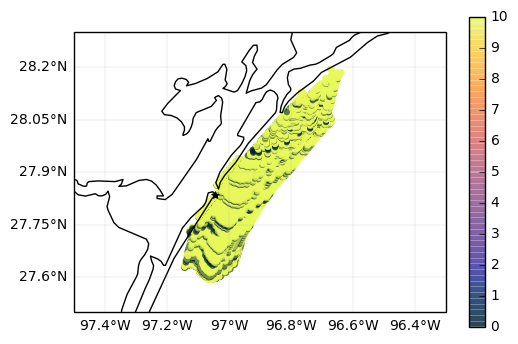

In [89]:
Files = glob('tracks/' + fullname + '*.nc')

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False
ax.set_extent([-97.5, -96.3, 27.5, 28.3], ccrs.PlateCarree())
# ax.set_extent([-97.5, -94.9, 27.5, 29.1], ccrs.PlateCarree())
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

for File in Files:
#     d = xr.open_dataset(File)
    d = netCDF.Dataset(File)
    lonp = d['lonp'][:,:]
    latp = d['latp'][:,:]
    zp = d['zp'][:,:]
    d.close()
    mapp = ax.scatter(lonp.T, latp.T, s=20, c=zp, cmap=cmo.thermal, transform=ccrs.PlateCarree(), linewidths=0, vmin=0,vmax=10, alpha=0.6);

fig.colorbar(mapp)
ax.plot([lonpa, lonss], [latpa, latss], 'k*', transform=ccrs.PlateCarree())
# figname = 'figures/.png'
# fig.savefig(figname, bbox_inches='tight')


### Asterionellopsis: Origin of surface drifters reaching Port Aransas and freeport 

Model drifters over this time period as they arrive at Port Aransas and Surfside. See if they experience similar conditions for the time periods that they both see the plankton. Start simulations from May 24 through June 1 and run them each backward in time for a week to see if they have a similar source.

In [21]:
# species and therefore simulation name
speciesname = 'Asterionellopsis'
nd = '2d'
case = 'tosspa'  # to surfside and port aransas

fullname = speciesname + '/' + nd + '/' + case + '/'

if not os.path.exists('tracks/' + fullname):
    os.mkdir('tracks/' + fullname)

overallstartdate = datetime(2017, 5, 24, 0)

date = overallstartdate

# keep running until we hit end date
while date <= datetime(2017, 5, 29, 0):

    name = fullname + date.isoformat()[0:13]
    enddate = date - timedelta(days=14)  # stop N days before the start
    # If the particle trajectories have not been run, run them
    if not os.path.exists('tracks/' + name + '.nc') and \
        not os.path.exists('tracks/' + name + 'gc.nc'):

        tp, lon0, lat0 = init(name, date, enddate, dx=1000, do3d=0, startarea='sspa', ff=-1)
        lonp, latp, zp, t, T0, U, V = tracpy.run.run(tp, date, lon0, lat0)

    # Increment by N hours for next loop
    date = date + timedelta(hours=24)


theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
Using GCM model output index  0
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
Using GCM model output index  1
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
Using GCM model output index  2
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretchi

theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4


AttributeError: 'list' object has no attribute 'autoscale_None'

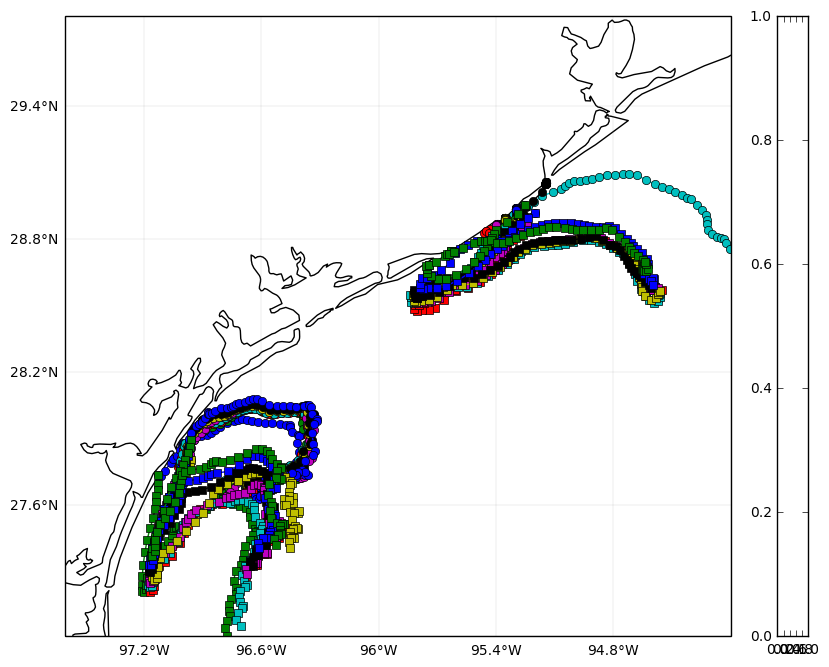

In [22]:
speciesname = 'Asterionellopsis'
nd = '2d'
case = 'tosspa'  # to surfside and port aransas

fullname = speciesname + '/' + nd + '/' + case + '/'
# Files = glob('tracks/' + fullname + '*.nc')

Files = ['tracks/' + fullname + '/2017-05-25T00.nc', 'tracks/' + fullname + '/2017-05-28T00.nc']
proj = tracpy.tools.make_proj(setup='nwgom-pyproj')
grid = tracpy.inout.readgrid(locgrid, proj, usespherical=True)
nc = netCDF.Dataset(loc)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False
# ax.set_extent([-97.5, -96.3, 27.5, 28.3], ccrs.PlateCarree())
ax.set_extent([-97.6, -94.2, 27.0, 29.8], ccrs.PlateCarree())
ax.coastlines(resolution='10m')  # coastline resolution options are '110m', '50m', '10m'

# File = Files[0]
for i, File in enumerate(Files):
    if i == 0:
        marker = 'o'
    elif i == 1:
        marker = 's'
#     d = xr.open_dataset(File)
    d = netCDF.Dataset(File)
    lonp = d['lonp'][::30,::20]
    latp = d['latp'][::30,::20]
    tp = d['tp'][0,::20]
    d.close()
    # interpolate scalars onto drifter paths
#     xg, yg, _ = tracpy.tools.interpolate2d(lonp, latp, grid, 'd_ll2ij')
#     var = tracpy.calcs.Var(xg, yg, tp[::-1], 'temp', nc, units='seconds since 1970-01-01')
#     var = var[:,::-1]

    mapp = ax.plot(lonp.T, latp.T, marker=marker, transform=ccrs.PlateCarree());#, vmin=25.4,vmax=26.6);
#     mapp = ax.scatter(lonp.T, latp.T, s=50, c=tp[np.newaxis,:], marker=marker, cmap=cmo.thermal, transform=ccrs.PlateCarree(), linewidths=0);#, vmin=25.4,vmax=26.6);
#     mapp = ax.scatter(lonp.T, latp.T, s=50, c=var, marker=marker, cmap=cmo.thermal, transform=ccrs.PlateCarree(), linewidths=0, vmin=25.4,vmax=26.6);

fig.colorbar(mapp)
ax.plot([lonpa, lonss], [latpa, latss], 'k*', transform=ccrs.PlateCarree())
# figname = 'figures/.png'
# fig.savefig(figname, bbox_inches='tight')


In [39]:
ind = var >1e30
var[ind] = np.nan
np.nanmax(var)

27.349903

Aside: make a path in lat/lon that contains the shelf grid without the bays. Start from the path I have previously clicked out that has boxes along the coastline outside of the bays. Use part of this and connect it with the rest of the numerical domain to exclude the bay.

theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4
theta_s not in valid range for Vstretching == 4
theta_b not in valid range for Vstretching == 4


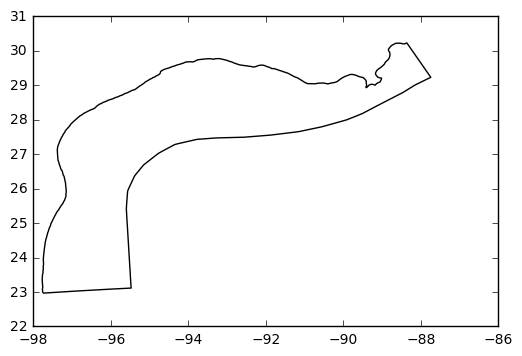

In [89]:
d2 = np.load('../shelf_transport/calcs/coastpaths.npz')
xp, yp = d2['outerpathxy'].item().vertices[:,0], d2['outerpathxy'].item().vertices[:,1]
proj = tracpy.tools.make_proj(setup='nwgom')  # need to use basemap with exact settings I used in the past for the path projection
grid = tracpy.inout.readgrid(locgrid, proj, usespherical=True)  # Read in grid
lonp, latp = grid.proj(xp, yp, inverse=True)
# combine with numerical grid
lon = np.hstack((lonp[:343], grid.lon_rho[0,-1], grid.lon_rho[0,::-1], grid.lon_rho[:162,0]))
lat = np.hstack((latp[:343], grid.lat_rho[0,-1], grid.lat_rho[0,::-1], grid.lat_rho[:162,0]))

grid = xr.open_dataset(locgrid)
plt.plot(lon, lat, 'k')

from matplotlib.path import Path
path = Path(np.vstack((lon, lat)).T)

np.savez('calcs/domain_path_nobays.npz', lon=lon, lat=lat, path=path)

# New experiments

Run surface drifters starting from both Port Aransas and Surfside. They have cell data from May 23 to June 30, 2017.

I will run simulations starting daily May 30 through June 30 and each running backward for a week.

Then plot together and look for any overlap

In [5]:
def init_back(name, startdate, ndays, dx, do3d, startarea, ff=1):
    
    time_units = 'seconds since 1970-01-01  00:00:00'

    nsteps = 10

    # Number of steps to divide model output for outputting drifter location
    N = 4
    
    ff = -1

#     # Number of days
#     ndays = (enddate-startdate).total_seconds()/86400.
#     if ff == -1:  # don't want negative days for backward running case
#         ndays = abs(ndays)

    # Time between outputs
    tseas = 3600.  # time between output in seconds
    ah = 0.
    av = 0.  # m^2/s

    # for 3d flag, do3d=0 makes the run 2d and do3d=1 makes the run 3d
    doturb = 0

    # for periodic boundary conditions in the x direction
    doperiodic = 0

    # Flag for streamlines. All the extra steps right after this are for streamlines.
    dostream = 0

    proj = tracpy.tools.make_proj(setup='nwgom-pyproj')

    # Read in grid
    grid = tracpy.inout.readgrid(locgrid, proj, usespherical=True)

    # get seed locations for drifters
    if startarea == 'pa' or startarea == 'ss':
        lon0, lat0 = seeds(startarea, dx, grid)
    elif startarea == 'sspa':
        lon0a, lat0a = seeds('pa', dx, grid)
        lon0b, lat0b = seeds('ss', dx, grid)
        lon0 = np.hstack((lon0a, lon0b))
        lat0 = np.hstack((lat0a, lat0b))

    ## Choose method for vertical placement of drifters
    if do3d:  # 3d
        z0 = np.zeros(lon0.shape)
        zpar = 'fromZeta'
    else:  # 2d
        z0 = 's'
        zpar = 29

    # Initialize Tracpy class
    tp = Tracpy(loc, grid, name=name, tseas=tseas,
                ndays=ndays, nsteps=nsteps, N=N, ff=ff, ah=ah, av=av,
                doturb=doturb, do3d=do3d, z0=z0, zpar=zpar,
                time_units=time_units, usespherical=True)

    return tp, lon0, lat0


In [7]:
# species and therefore simulation name
speciesname = 'run1'
# nd = '2d'

ndays = 7
fullname = speciesname# + '/' + nd

if not os.path.exists('tracks/' + fullname):
    os.mkdir('tracks/' + fullname)

overallstartdate = datetime(2017, 5, 30, 0)
enddate = datetime(2017, 6, 30, 0)

date = overallstartdate

# keep running until we hit end date
while date <= enddate:

    name = fullname + date.isoformat()[0:13]

    # If the particle trajectories have not been run, run them
    if not os.path.exists('tracks/' + name + '.nc') and \
        not os.path.exists('tracks/' + name + 'gc.nc'):

        tp, lon0, lat0 = init_back(name, date, ndays, dx=1000, do3d=0, startarea='sspa')
        lonp, latp, zp, t, T0, U, V = tracpy.run.run(tp, date, lon0, lat0)

    # Increment by 24 hours for next loop
    date = date + timedelta(hours=24)


NameError: name 'tracpy' is not defined